# Title: csck700_1_2_ifc_parser

### The module parses an IFC model to extract the IFcElements, their properties and relationships and loads them to nodes and edges into Neo4J.

# 0. Table of content:

- [1. Settings:](#1.-Settings:)  
- [2. Imports:](#2.-Imports:)  
- [3. Helper functions:](#3.-Helper-functions:)  
    - [3.1. Proxy entities handling:](#3.1.-Proxy-entities-handling:)  
    - [3.2. IfcRelationships - Edges:](#3.2.-IfcRelationships---Edges:)  
    - [3.3. IfcEntities - Nodes:](#3.3.-IfcEntities---Nodes:)  
    - [3.4. Sanity Checks:](#3.3.-Sanity-Checks:)
    - [3.5. Nodes insertion & Relationshsips/edges insertion:](#3.5.-Nodes-insertion-&-Relationshsips/edges-insertion:)
    - [3.6. Graph integrity:](#3.6.-Graph-integrity:)
- [4. Data load:](#4.-Data-load:)
- [5. Proxy entities handling:](#5.-Proxy-entities-handling:)  
- [6. IFC Parsing:](#5.-IFC-Parsing:)  
    - [6.1. IfcRelationships - Edges Preparation:](#6.1.-IfcRelationships---Edges-Preparation:)  
    - [6.2. IfcEntities - Nodes Preparation:](#6.2.-IfcEntities---Nodes-Preparation:)  
    - [6.3. Sanity Checks:](#6.3.-Sanity-Checks:)  
- [7. Neo4J graph:](#7.-Neo4J-graph:)
    - [7.1. Graph creation:](#7.1.-Graph-creation:)  
    - [7.2. Graph integrity:](#7.2.-Graph-integrity:)
    - [7.3. Exploration & visualization:](#7.3.-Exploration-&-visualization:)
    - [7.4. Graph summary:](#7.4.-Graph-summary:)      

# 1. Settings:

In [1]:
IFC_PATH = r"..\data\raw\Building-Structural.ifc"

NEO4J_URI = "bolt://localhost:7687"
NEO4J_USER = "neo4j"
NEO4J_PASSWORD = "TitineTiteFiro@1952"
DATABASE = "capstone"

In [2]:
REL_MAP ={
    "IfcRelDefinesByProperties": ("RelatingPropertyDefinition", "RelatedObjects", None),
    "IfcRelDefinesByType": ("RelatingType", "RelatedObjects", "DEFINED_BY_TYPE"),
    "IfcRelAssociatesMaterial": ("RelatingMaterial", "RelatedObjects", "ASSOCIATED_MATERIAL"),
    "IfcRelContainedInSpatialStructure": ("RelatingStructure", "RelatedElements", "CONTAINED_IN"),
    "IfcRelAggregates": ("RelatingObject", "RelatedObjects", "AGGREGATES"),
    "IfcRelAssociatesClassification": ("RelatingClassification", "RelatedObjects", "ASSOCIATED_CLASSIFICATION")
} 

# 2. Imports:

In [3]:
from IPython.display import Image, display
import ifcopenshell
import ifcopenshell.util.element as util
from neo4j import GraphDatabase
from collections import Counter, defaultdict
# !pip install deepdiff
from deepdiff import DeepDiff
# !pip install yfiles-jupyter-graphs-for-neo4j
from yfiles_jupyter_graphs_for_neo4j import Neo4jGraphWidget
import json
from IPython.display import JSON, display

# 3. Helper functions:

## 3.1. Proxy entities handling:

In [4]:
def proxies_analysis(model):
    """
    Identify proxy elements, their related relationships, and dependent entities
    that only exist through those relationships.
    """

    # proxies identification:
    proxies = {ent for ent in model if "Proxy" in ent.is_a()}

    # relationships involved in proxies:
    proxies_rels = {
        r
        for p in proxies
        for r in model.get_inverse(p)
        if hasattr(r, "is_a") and r.is_a("IfcRelationship")
    }

    # other-side entities, non-proxy, non-relationship:
    others = {
        e 
        for r in proxies_rels
        for v in r.get_info().values()
        for e in (v if isinstance(v, (list, tuple, set)) else [v])
        if hasattr(e, "is_a") and not e.is_a("IfcRelationship") and e not in proxies
    }

    # isolated: no other relationship beyond proxy_rels:
    isolated = {
        o for o in others
        if not any(r for r in model.get_inverse(o)
                  if hasattr(r, "is_a") and r.is_a("IfcRelationship") and r not in proxies_rels)
    }

    return proxies, proxies_rels, isolated

In [5]:
def proxies_drop(model):
    """
    Remove proxy elements, their associated relationships, and dependent isolated entities
    from the IFC model to produce a cleaned version.
    """

    proxies, proxies_rels, isolated = proxies_analysis(model)

    # remove relationships that touch proxies:
    for r in list(proxies_rels):
        if hasattr(r, "is_a") and r.is_a("IfcRelContainedInSpatialStructure"):
            # keep non-proxy elements in the relationship
            elems = list(getattr(r, "RelatedElements", []) or [])
            keep = [e for e in elems if "Proxy" not in e.is_a()]
            if len(keep) == 0:
                model.remove(r)
            else:
                r.RelatedElements = keep   # IfcOpenShell allows setting lists
            continue
        # other relationship types can be removed as before
        model.remove(r)

    # remove ensuing isolated nodes:
    for i in isolated:
        # # run("entity.remove", model, entity=i)
        try:
            model.remove(e)
        except Exception:
            pass

    # remove proxies:
    for p in proxies:
        # run("entity.remove", model, entity=p)
        try:
            model.remove(p)
        except Exception:
            pass

    print("\n====PROXIES REMOVAL COUNTS:====\n")
    print(f"relationships: {len(proxies_rels)}")
    print(f"isolated nodes: {len(isolated)}")
    print(f"proxies: {len(proxies)}") 

    return model

In [6]:
# def proxies_drop(model):
#     """
#     Remove proxy elements, their associated relationships, and dependent isolated entities
#     from the IFC model to produce a cleaned version.
#     """

#     proxies, proxies_rels, isolated = proxies_analysis(model)

#     # remove relationships that touch proxies:
#     for r in proxies_rels:
#         # run("entity.remove", model, entity=r)
#         model.remove(r)

#     # remove ensuing isolated nodes:
#     for i in isolated:
#         # # run("entity.remove", model, entity=i)
#         try:
#             model.remove(e)
#         except Exception:
#             pass

#     # remove proxies:
#     for p in proxies:
#         # run("entity.remove", model, entity=p)
#         try:
#             model.remove(p)
#         except Exception:
#             pass

#     print("\n====PROXIES REMOVAL COUNTS:====\n")
#     print(f"relationships: {len(proxies_rels)}")
#     print(f"isolated nodes: {len(isolated)}")
#     print(f"proxies: {len(proxies)}") 

#     return model

## 3.2. IfcRelationships - Edges:

In [7]:
def identify_rel(model):
    """
    Identify all distinct IfcRelationship classes present in the model.
    """

    rel_classes = set()

    rels = model.by_type("IfcRelationship")

    for rel in rels:
        rel_classes.add(rel.is_a())

    print("Identified relationship classes:")  
    for r in rel_classes:
        print(f"- {r}.")
        
    return rel_classes

In [8]:
def obj_id(o):
    """
    Returns the GUID of the given object, if present, else synthetic ClassName:step_id.

    Non-IfcRoot entities (e.g. IfcMaterial, IfcClassificationReference)
    do not have a GlobalId, so the fallback ensures uniqueness.
    """
    return getattr(o, "GlobalId", f"{o.is_a()}:{o.id()}")

In [9]:
def as_list(v):
    """
    Normalize to a list: pass through lists/tuples, [] for None, wrap scalars as [v].
    Does not expand custom collections; handle those explicitly.
    """
    if isinstance(v, (list, tuple)):
        return v
    elif v is None:
        return []
    else:
        return [v]

In [10]:
def edges_maker(model, rel_map=REL_MAP, pset_qto=True):
    """
    For a given model, creates a dictionary of edges (IfcRelationships exploded into from -> to pairs.
    For IfcRelContainedInSpatialStructure, expand RelatedElements by index.
    Returns:
        - edges: a dictionary of edges with keys:
            - id, labels, rel_class, rel_id, from, to.
    """

    edges = dict()
    pairs = set()

    for rel_class, (relating_attr, related_attr, label) in rel_map.items():
        for rel in model.by_type(rel_class):
            relating = getattr(rel, relating_attr, None)
            related = getattr(rel, related_attr, None)
            if relating is None:
                continue
            
            # distinction property set vs quantity set:
            if rel_class == "IfcRelDefinesByProperties":
                if pset_qto and relating.is_a("IfcElementQuantity"):
                    edge_label = "DEFINED_BY_QUANTITIES"
                else:
                    edge_label = "DEFINED_BY_PROPERTIES"
            else:
                edge_label = label

            frm = obj_id(relating)
            rel_gid = obj_id(rel)

            ###########
            # special-case, spatial containment IfcOpenshell collection unwrapping:
            if rel_class == "IfcRelContainedInSpatialStructure" and related_attr == "RelatedElements":
                rel_elems = getattr(rel, "RelatedElements", None)
                # IMPORTANT: do NOT use "or []" here; some IfcOpenShell collections are falsey
                n = len(rel_elems) if rel_elems is not None else 0
                related_items = [rel_elems[i] for i in range(n)]
                # ensure label if coming blank from REL_MAP (usually already 'CONTAINED_IN')
                if not edge_label:
                    edge_label = "CONTAINED_IN"
            else:
                # default behavior (your original as_list)
                related_items = as_list(related)
            ###########
            
            # one-to-many relationships:
            for r in as_list(related):
                if r is None:
                    continue
                to  = obj_id(r)
                
                # sanity check:
                pairs.add((rel_gid, frm, to))
                
                edge_id = f"{rel_gid}:{frm}->{to}"
                edges[edge_id]={
                    "id": edge_id,
                    "labels": edge_label,
                    "rel_class": rel_class,
                    "rel_id": rel_gid,
                    "from_id": frm,
                    "to_id": to
                }

    expected = len(pairs)
    actual = len(edges)
    
    return expected, actual, edges

## 3.3. IfcEntities - Nodes:

In [11]:
def get_entity_from_id(model, oid):
    """
    Returns the Ifc entity from the given id or GUID.
    """

    if isinstance(oid, str) and (len(oid) == 22) and (":" not in oid):
        return model.by_guid(oid)

    elif ":" in oid:
        try:
            step_id = int(oid.split(":")[-1])
            return model.by_id(step_id)
        except Exception:
            return None

    return None

In [12]:
def get_entities_from_edges(model, edges, typ):
    """
    Returns the relating or related Ifc entities from a dict of edges.
    """

    entities_from_edges = []
    
    for edge in edges.values():
        obj = get_entity_from_id(model, edge[typ])
        if obj:
            entities_from_edges.append(obj) 

    return entities_from_edges

In [13]:
def merge_unique(obj1, obj2):
    """
    Returns a list of unique Ifc entities from two lists of Ifc entities.
    """
    merged = dict()
    for o in obj1 + obj2:
        if o:
            merged[obj_id(o)] = o
    return list(merged.values())

In [14]:
def entities_classes_identify(all_objects):
    """
    Identifies the Ifc entity classes present in the model.
    All IfcElements subtypes collapse to 'IfcElement'.
    All *Type classes collapse to 'IfcTypeObject'.
    """

    clss = set()
    
    for o in all_objects:
        if o.is_a("IfcElement"):
            clss.add("IfcElement")
        elif "Type" in o.is_a():
            clss.add("IfcTypeObject")
        else:
            clss.add(o.is_a())

    return clss

In [15]:
def props_identify(all_objects):

    props = {}

    pset = "IfcPropertySet"
    qset = "IfcElementQuantity"

    for o in all_objects:
        if o.is_a(pset):
            props.setdefault(pset, dict())
            for p in o.HasProperties:
                props[pset][p.Name] = {
                    "property_type": p.is_a()
                }
                
        elif o.is_a(qset):
            props.setdefault(qset, dict())
            for q in o.Quantities:
                props[qset][q.Name] = {
                    "property_type": q.is_a()
                }

    # only IfcMaterial class, no specific material properties to extract beyond the material name.
                
    return props

In [16]:
def pset_props_collect(o):
    """
    Extracts the properties from an IfcPropertySet entity. 
    """

    def unwrap(v):
        """
        Converts an Ifc value wrapper to a plain Python type.
        """
        if v is None:
            return None
        else:
            return getattr(v, "wrappedValue", v)

    props = {}
    
    for p in o.HasProperties:
        if p.is_a("IfcPropertySingleValue"):
            nv = getattr(p, "NominalValue", None)
            props[p.Name] = {
                "kind": "SingleValue",
                "value": unwrap(nv)
            }
        elif p.is_a("IfcPropertyEnumeratedValue"):
            vals = [unwrap(v) for v in (getattr(p, "EnumerationValues", []) or [])]
            enum_ref = getattr(p, "EnumerationReference", None)
            domain = (
                [unwrap(v) for v in (getattr(enum_ref, "EnumerationValues", []) or [])]
                if enum_ref else None
            )
            props[p.Name] = {
                "kind": "EnumeratedValue",
                "value": vals if len(vals) != 1 else vals[0],
                "enumeration_name": getattr(enum_ref, "Name", None) if enum_ref else None,
                "domain": domain
            }

    # if needed, to be developed to handle other kinds of properties.
        
    return props

In [17]:
def qset_props_collect(o, include_none=False):
    """
    Extracts the quantitiy properties from an IfcElementQuantity. 
    """

    props = {}
    
    for q in getattr(o, "Quantities", []) or []:
        val = None
        if q.is_a("IfcQuantityLength"):
            val = q.LengthValue
        elif q.is_a("IfcQuantityArea"):
            val = q.AreaValue
        elif q.is_a("IfcQuantityVolume"):
            val = q.VolumeValue
        elif q.is_a("IfcQuantityCount"):
            val = q.CountValue
        elif q.is_a("IfcQuantityWeight"):
            val = q.WeightValue

        if include_none or val is not None:  
            props[q.Name] = {
                "kind": q.is_a(),
                "value": val
            }

    return props

In [18]:
def node_set(o):
    """
    Extract the node information for a single Ifc entity.
    """

    node = dict()

    # helpers:
    def g_n(o, name, default=None):
        """
        Extract an attribute for an Ifc entity.
        """
        return getattr(o, name, default)

    def basic_props(label, addition=None):
        """
        Set the base node dictionary for an Ifc entity and add it to "node".
        """
        node_id = obj_id(o)
        base = {
            "id": node_id,
            "labels": [label, o.is_a()],
            "name": g_n(o, "Name")
        }
        if addition:
            base.update(addition)
        node[node_id] = base

    
    cls = o.is_a()

    if cls == "IfcProject":
        basic_props("PROJECT")
        
    elif o.is_a("IfcElement"):
        # ObjectType fallback:
        basic_props("ELEMENT", {
            "predefined_type": g_n(o, "PredefinedType", g_n(o, "ObjectType"))
        })
        
    elif cls == "IfcPropertySet":
        basic_props("PSET", {
            "properties": pset_props_collect(o)
        })
        
    elif cls == "IfcElementQuantity":
        basic_props("QSET", {
            "quantities": qset_props_collect(o)
        })
        
    elif "Type" in cls:
        basic_props("TYPE")
        
    elif cls == "IfcMaterial":
        basic_props("MATERIAL")
        
    elif cls in ("IfcSite", "IfcBuilding", "IfcBuildingStorey", "IfcSpace"):
        basic_props("SPATIAL")
        
    elif cls == "IfcClassificationReference":
        scheme = g_n(o, "ReferencedSource") # IfcClassification
        basic_props("CLASSIFICATION_REF",{
            "code": g_n(o, "Identification"),
            "uri": g_n(o, "Location"),
            # link to IfcClassification by id:
            "scheme_id": obj_id(scheme) if scheme else None,
        })

    # cleanup:
    for node_id, props in node.items():
        for k, v in list(props.items()):
            if v is None:
                props[k] = "MISSING"

    return node        

In [19]:
def nodes_maker(all_objects):
    """
    For a given model, creates a dictionary of nodes from a list of Ifc entities.
    """

    nodes = {}

    for o in all_objects:
        nodes.update(node_set(o))

    return nodes

In [20]:
def flatten_dict(d, parent_key="", sep="_"):
    """
    Recursively flatten a nested dictionary.
    """
    items = {}
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.update(flatten_dict(v, new_key, sep=sep))
        else:
            items[new_key] = v
    return items

In [21]:
def nodes_flatten(nodes):
    """
    Flatten nested dictionaries in node attributes for Neo4J comptability.
    """

    def flatten_dict(d, parent_key="", sep="::"):
        """
        Recursively flatten a nested dictionary.
        """
        items = {}
        for k, v in d.items():
            new_key = f"{parent_key}{sep}{k}" if parent_key else k
            if isinstance(v, dict):
                items.update(flatten_dict(v, new_key, sep=sep))
            else:
                items[new_key] = v
        return items

    nodes_ready = dict()
    
    for node in nodes.values():
        # preserve "labels"
        base = {k: v for k, v in node.items() if k != "labels"}
        flat = flatten_dict(base)
        flat["labels"] = node["labels"]
        nodes_ready[node["id"]] = flat

    return nodes_ready

## 3.4. Sanity Checks:  

In [22]:
def elements_inspection(model, ifc_type="IfcProduct"):
    """
    Counts and lists IfcElements (excluding proxies in this case) grouped by class.
    Returns:
        - elements: list.
        - classes_counter: Counter.
    """
    
    products = model.by_type(ifc_type)
    elements = [p for p in products if (p.is_a("IfcElement")) and not (p.is_a("IfcBuildingElementProxy"))]
    elements_classes = [el.is_a() for el in elements]
    classes_counter = Counter(elements_classes)

    print(f"Total number of elements: {len(elements)}")
    for cl, count in classes_counter.items():
        print(f"{cl}: {count}.")

    return classes_counter

In [23]:
def sanity(expected, actual, relating, related):
    """
    Sanity checks:
        - Proxies presence.
        - Edge count.
        - Relating entities count.
        - Related entities count.
        - Union nodes.
    Returns:
        bool: True if all checks pass, else False.
    """
    passed = True

    proxies = []
    
    for e in all_ents:
        if "Proxy" in e.is_a():
            proxies.append(e.id())

    if len(proxies) == 0:
        print("Proxy check passed, there is no Proxy entity.")
    else:
        print(f"ERROR: Presence of Proxy entities: {proxies}")
        passed = False 
            
    if expected == actual:
        print(f"Edge count check passed: expected and actual are consistent ({actual}).")
    else:
        print(f"ERROR: edges count mismatch - expected {expected} but got {actual}.")
        passed = False
        
    if len(relating) == actual:
        print(f"Relating entities count check passed: {len(relating)} = number of edges ({actual}).")
    else:
        print(f"ERROR: relating entities count mismatch - edges {actual}, relating entities {len(relating)}.")
        passed = False
        
    if len(related) == actual:
        print(f"Related entities count check passed: {len(related)} = number of edges ({actual}).")
    else:
        print(f"ERROR: related entities count mismatch - edges {actual}, related entities {len(related)}.")
        passed = False

    relating_set = set(relating)
    related_set = set(related)
    union_nodes = relating_set | related_set

    if len(union_nodes) >= max(len(relating_set), len(related_set)):
        print(f"Unique node union check passed: |union|={len(union_nodes)}, |relating|={len(relating_set)}, |related|={len(related_set)}")
    else:
        print(f"ERROR: union size invalind - |union|={len(union_nodes)}, |relating|={len(relating_set)}, |related|={len(related_set)}")

    print(f"The overall sanity check has been succesfully passed: {passed}.")

## 3.5. Nodes insertion & Relationshsips/edges insertion:

In [24]:
def driver_merge(ents, entity=None):
    """
    Merge nodes or edges into Neo4J from prepared dictionaries.

    Note: for relationships we MERGE on our synthetic edge `id` (edge_id), not on `rel_id`.
    When unwrapping IfcOpenShell collections (e.g., RelatedElements), multiple edges share
    the same IFC `rel_id`; using `edge_id` guarantees each (rel, from, to) pair becomes a
    unique relationship while still storing `rel_id` for traceability.
    """

    with driver.session(database=DATABASE) as session:

        if entity == "node":

            for node in ents.values():
                labels = ":"+":".join(node["labels"])
                
                # def _normalize(v):
                #     """
                #     In Neo4J, attributes/properties cannot be null,
                #     """
                #     return "MISSING" if v is None else v

                attr = {k: v for k, v in node.items() if k not in ("labels", "id")}
        
                cypher_node = f"""
                MERGE (n{labels}{{id: $id}})
                SET n += $attr
                """
        
                session.run(cypher_node, {"id": node["id"], "attr": attr}) 

        elif entity == "edge":

            for edge in ents.values():
                attr = {k: v for k, v in edge.items() if k not in ("from", "to", "from_id", "to_id", "labels", "rel_id", "id")}
        
                cypher_edge = f"""
                MATCH (a {{id: $from_id }}), (b {{id: $to_id}})
                MERGE (a)-[r:{edge["labels"]}{{id: $edge_id}}]->(b)
                SET r.rel_id  = $rel_id,
                    r.from_id = $from_id,
                    r.to_id = $to_id,
                    r += $attr
                REMOVE r.from, r.to 
                """
        
                session.run(cypher_edge, {
                    "from_id": edge["from_id"],
                    "to_id": edge["to_id"],
                    "edge_id": edge["id"],
                    "rel_id": edge["rel_id"],
                    "attr": attr
                        })  

## 3.6. Graph integrity:

In [25]:
def graph_integrity(dict1, dict2, label_type=None):
    """
    Compare two dictionaries for integrity.
    Print whether they match and detail differences if not.
    """

    passed = (dict1 == dict2)
    diff = DeepDiff(dict1, dict2, significant_digits=6)

    label = label_type.upper() if label_type else "GRAPH"
    
    if passed:
        print(f"{label} - the graph integrity is assured: {passed}")
    else:
        print(f"{label} - the graph integrity is assured: {passed}")
        print("Differences:")
        print(diff)

    return passed, diff 

# 4. Data load:

In [26]:
model = ifcopenshell.open(IFC_PATH)

In [27]:
driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

# 5. Proxy entities handling:

## Proxy Cleanup Strategy

Proxy elements are removed at the start of the workflow to maintain a clean and semantically consistent graph.

1. **Dropping proxies**  
   In this dataset, proxies represent geolocation artifacts or placeholders. They provide no analytical value but increase noise and graph size.

2. **Early removal**  
   Performing the cleanup at the beginning simplifies the workflow by eliminating the need for repeated exclusions later and by preventing dangling references in subsequent steps.

3. **Related relationships and dependent entities**  
   Proxies are often connected through relationships (e.g., `IfcRelDefines*`, `IfcRelAssociates*`) and may reference entities that exist only through those links. Removing both the relationships and such dependent entities avoids the presence of isolated nodes.

4. **Deletion order**  
   - Relationships connected to proxies are deleted first to ensure a clean break.  
   - Dependent isolated entities are removed next, as they then have degree zero.  
   - Finally, the proxies themselves are removed.  

This sequence ensures a compact, consistent model without dangling edges or orphaned entities.

In [28]:
model = proxies_drop(model)


====PROXIES REMOVAL COUNTS:====

relationships: 8
isolated nodes: 3
proxies: 5


# 6. IFC Parsing:

The parsing process begins with the IfcRelationships, from which a dictionary of Edges is created to support Neo4j graph construction. Each edge captures the "from" and "to" attributes that define the connected IFC entities. Based on these connections, all distinct entities can be identified and represented in a dictionary of Nodes. Inverse relationships are not included, as Neo4j inherently supports bidirectional traversal of edges; storing them explicitly would only duplicate information and increase memory usage. Proxy entities are removed in this model, as they are not significant building elements but instead geolocation artifacts.   

To ensure consistency, node identifiers are normalized (e.g. through unique obj_id values), and key metadata such as IFC class labels and relevant properties are attached to nodes and edges. This guarantees that the resulting graph remains both semantically clear and efficient for querying.  

In [29]:
picture_path = r"..\data\raw\Building_Structural_picture.png"

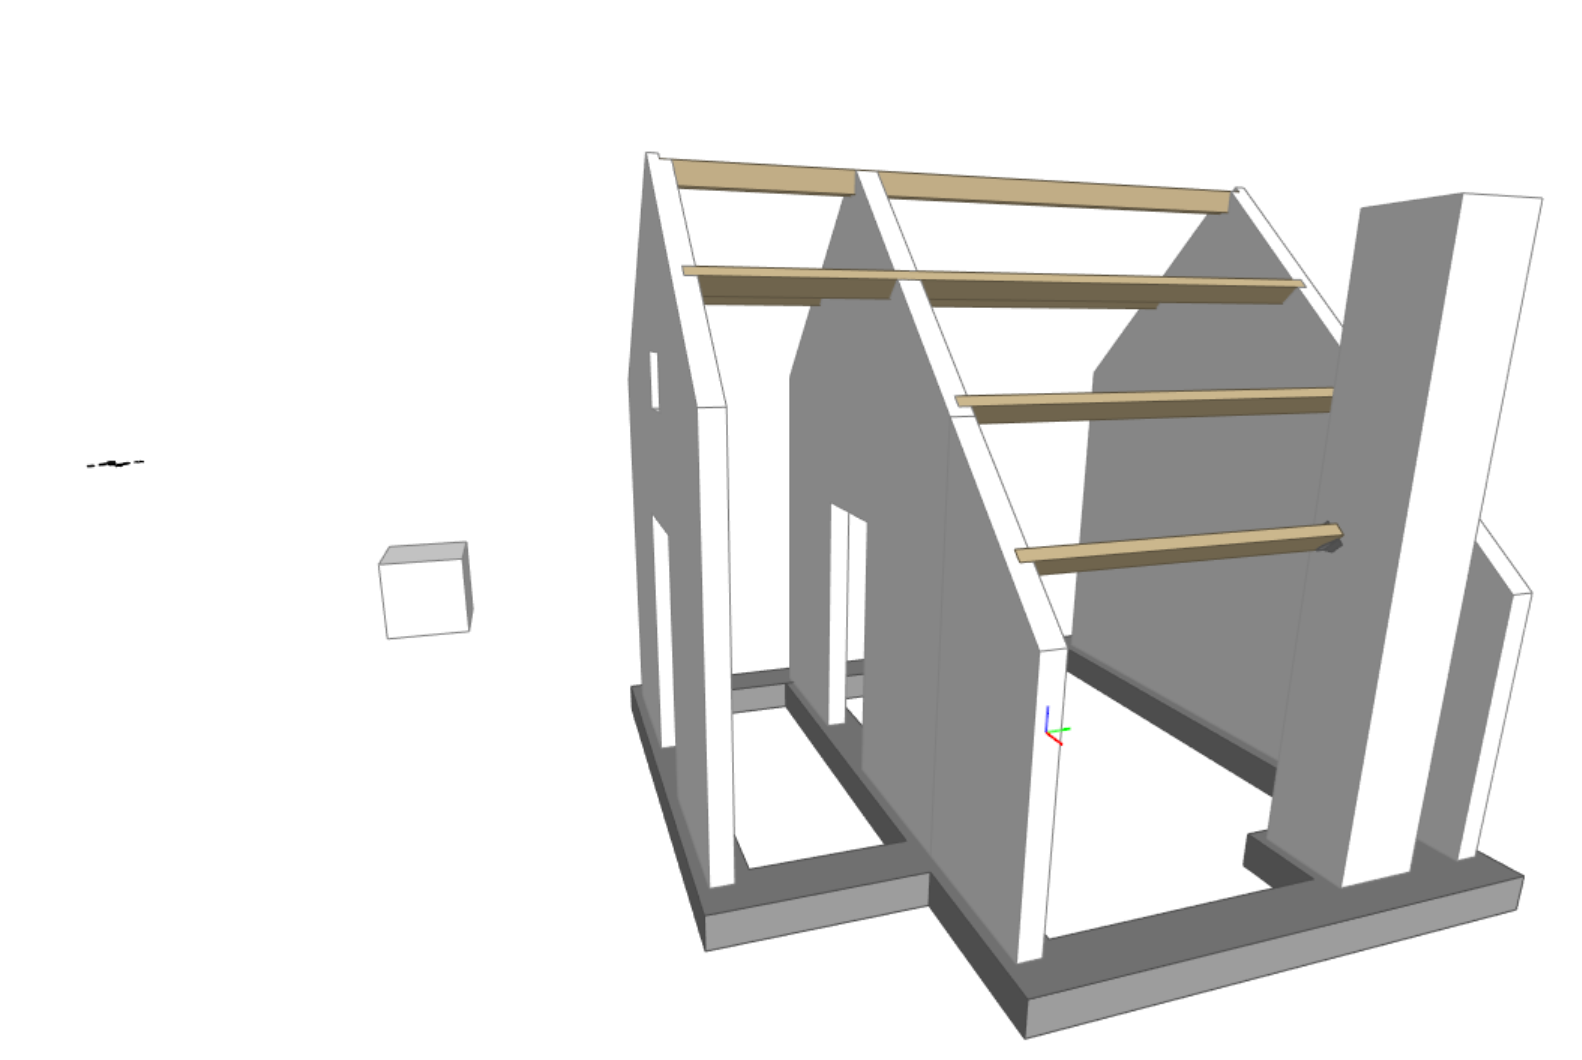

In [30]:
display(Image(filename=picture_path))

## 6.1. IfcRelationships - Edges Preparation:

### 6.1.1. Functions Building Guidance:

**edges_maker:**

In [31]:
identify_rel(model)

Identified relationship classes:
- IfcRelDefinesByType.
- IfcRelAssociatesClassification.
- IfcRelDefinesByProperties.
- IfcRelAssociatesMaterial.
- IfcRelContainedInSpatialStructure.
- IfcRelAggregates.


{'IfcRelAggregates',
 'IfcRelAssociatesClassification',
 'IfcRelAssociatesMaterial',
 'IfcRelContainedInSpatialStructure',
 'IfcRelDefinesByProperties',
 'IfcRelDefinesByType'}

### 6.1.2. Edges Dictionary:

In [32]:
expected, actual, edges = edges_maker(model)

In [33]:
edges

{'141p4IPfrBnRJ5dWbakDZK:18DB$FpSH4QhNntrrSRVGz->0c$N1CTon2BB2Sp89385G8': {'id': '141p4IPfrBnRJ5dWbakDZK:18DB$FpSH4QhNntrrSRVGz->0c$N1CTon2BB2Sp89385G8',
  'labels': 'DEFINED_BY_PROPERTIES',
  'rel_class': 'IfcRelDefinesByProperties',
  'rel_id': '141p4IPfrBnRJ5dWbakDZK',
  'from_id': '18DB$FpSH4QhNntrrSRVGz',
  'to_id': '0c$N1CTon2BB2Sp89385G8'},
 '37JtmMF1HE8uDDbwzFG43E:0hVJYXG1r7ywQAq8Vpug40->0DyViLJJ175RvWQi1rE7a6': {'id': '37JtmMF1HE8uDDbwzFG43E:0hVJYXG1r7ywQAq8Vpug40->0DyViLJJ175RvWQi1rE7a6',
  'labels': 'DEFINED_BY_PROPERTIES',
  'rel_class': 'IfcRelDefinesByProperties',
  'rel_id': '37JtmMF1HE8uDDbwzFG43E',
  'from_id': '0hVJYXG1r7ywQAq8Vpug40',
  'to_id': '0DyViLJJ175RvWQi1rE7a6'},
 '1SWTv4zQ95LhMduNc2qS5N:0VVWsZ$_bFHgmAwNtcydte->0DyViLJJ175RvWQi1rE7a6': {'id': '1SWTv4zQ95LhMduNc2qS5N:0VVWsZ$_bFHgmAwNtcydte->0DyViLJJ175RvWQi1rE7a6',
  'labels': 'DEFINED_BY_QUANTITIES',
  'rel_class': 'IfcRelDefinesByProperties',
  'rel_id': '1SWTv4zQ95LhMduNc2qS5N',
  'from_id': '0VVWsZ$_bFHgm

In [57]:
len(edges)

71

In [34]:
# print("Prepared CONTAINED_IN:", sum(1 for e in edges.values() if e["labels"] == "CONTAINED_IN"))

## 6.2. IfcEntities - Nodes Preparation:

### 6.2.1. Collect IfcEntities:

In [35]:
relating_ents = get_entities_from_edges(model, edges, "from_id")

In [36]:
related_ents = get_entities_from_edges(model, edges, "to_id")

In [37]:
all_ents = merge_unique(relating_ents, related_ents)

### 6.2.2. Functions Building Guidance:

**node_set:**

In [38]:
entities_classes_identify(all_ents)

{'IfcBuilding',
 'IfcBuildingStorey',
 'IfcClassificationReference',
 'IfcElement',
 'IfcElementQuantity',
 'IfcMaterial',
 'IfcProject',
 'IfcPropertySet',
 'IfcSite',
 'IfcTypeObject'}

**pset_props_collect & qset_props_collect:**

In [39]:
props = props_identify(all_ents)
props

{'IfcPropertySet': {'ConstructionMethod': {'property_type': 'IfcPropertySingleValue'},
  'Status': {'property_type': 'IfcPropertyEnumeratedValue'},
  'IsExternal': {'property_type': 'IfcPropertySingleValue'},
  'LoadBearing': {'property_type': 'IfcPropertySingleValue'}},
 'IfcElementQuantity': {'NetVolume': {'property_type': 'IfcQuantityVolume'},
  'Width': {'property_type': 'IfcQuantityLength'},
  'Length': {'property_type': 'IfcQuantityLength'},
  'NetSideArea': {'property_type': 'IfcQuantityArea'},
  'CrossSectionArea': {'property_type': 'IfcQuantityArea'}}}

### 6.2.3. Nodes dictionary:

In [40]:
nodes = nodes_maker(all_ents)

In [41]:
nodes

{'18DB$FpSH4QhNntrrSRVGz': {'id': '18DB$FpSH4QhNntrrSRVGz',
  'labels': ['PSET', 'IfcPropertySet'],
  'name': 'Pset_BuildingCommon',
  'properties': {'ConstructionMethod': {'kind': 'SingleValue',
    'value': 'new construction'}}},
 '0hVJYXG1r7ywQAq8Vpug40': {'id': '0hVJYXG1r7ywQAq8Vpug40',
  'labels': ['PSET', 'IfcPropertySet'],
  'name': 'Pset_WallCommon',
  'properties': {'Status': {'kind': 'EnumeratedValue',
    'value': 'UNSET',
    'enumeration_name': '#<BimTools::IfcManager::Types::IfcLabel:0x000001cc1a1a45b8>',
    'domain': ['NEW',
     'EXISTING',
     'DEMOLISH',
     'TEMPORARY',
     'OTHER',
     'NOTKNOWN',
     'UNSET']},
   'IsExternal': {'kind': 'SingleValue', 'value': True},
   'LoadBearing': {'kind': 'SingleValue', 'value': True}}},
 '0VVWsZ$_bFHgmAwNtcydte': {'id': '0VVWsZ$_bFHgmAwNtcydte',
  'labels': ['QSET', 'IfcElementQuantity'],
  'name': 'Qto_WallBaseQuantities',
  'quantities': {'NetVolume': {'kind': 'IfcQuantityVolume',
    'value': 4.28651536853961},
   'W

In [58]:
len(nodes)

56

### 6.2.4. Nodes dictionary flattening:

### Flattening the Nodes Dictionary

Neo4j node properties must be stored as **primitive types** (strings, numbers, booleans, lists).  
Nested dictionaries or maps are **not supported** as property values.  

The IFC parsing stage produces a `nodes` dictionary where attributes such as property sets or quantities may be stored as nested structures. To make these compatible with Neo4j:

- Each nested dictionary is **flattened** into key–value pairs (e.g., `{"Pset_WallCommon": {"FireRating": "2h"}}` becomes `{"Pset_WallCommon_FireRating": "2h"}`).
- The `"labels"` field is preserved separately to define the node categories in Neo4j.

This flattening step ensures that all node attributes can be safely inserted as Neo4j properties without loss of information or structural conflicts.

In [42]:
nodes = nodes_flatten(nodes)

## 6.3. Sanity Checks:

In [43]:
elements_distribution = elements_inspection(model)
# elements_distribution

Total number of elements: 15
IfcBeam: 6.
IfcChimney: 1.
IfcFooting: 1.
IfcRoof: 1.
IfcWall: 4.
IfcDiscreteAccessory: 2.


In [44]:
sanity(expected, actual, relating_ents, related_ents)

Proxy check passed, there is no Proxy entity.
Edge count check passed: expected and actual are consistent (71).
Relating entities count check passed: 71 = number of edges (71).
Related entities count check passed: 71 = number of edges (71).
Unique node union check passed: |union|=56, |relating|=42, |related|=19
The overall sanity check has been succesfully passed: True.


### **TO BE CHECKED:**
#### - Wall type seems to be duplicated in the graph. There should be 1 only wall type or 2 (interior/exterior).
#### - Beam type is OK = only 1 type.

# 7. Neo4J graph:

## 7.1. Graph creation:

To set up the Neo4j graph, both the **"nodes"** dictionary and the **"edges"** dictionary generated during the IFC parsing stage will serve as the input. These dictionaries represent the essential building blocks of the graph:  
- the **"nodes"** (with their labels, categories, types, attributes and properties/quantities)  
- the **"edges"** (with their relationship categories and endpoints)

They will be passed into Neo4j through the **Neo4j Python driver**, which manages the connection and Cypher queries used to create the graph.

### 7.1.1. Nodes insertion:

In [45]:
driver_merge(nodes, "node")

### 7.1.2. Relationships/edges insertion:

In [46]:
driver_merge(edges, "edge")

## 7.2. Graph integrity:

### 7.2.1. Nodes integrity:

In [47]:
with driver.session(database=DATABASE) as session:
    
    results = session.run(
        """
        MATCH (n)
        WHERE n.id IS NOT NULL
        RETURN n.id AS id, keys(n) AS prop_keys, labels(n) AS labs, n AS node
        """)
    
    nodes_dict = {}
    
    for r in results:
        nid = r["id"]
        labs = r["labs"]
        node = r["node"]   
        m = {k: node[k] for k in r["prop_keys"]}
        m["labels"] = labs
        nodes_dict[nid] = m

In [48]:
graph_integrity(nodes, nodes_dict, label_type="nodes")

NODES - the graph integrity is assured: True


(True, {})

### 7.2.2. Edges integrity:

In [49]:
with driver.session(database=DATABASE) as session:

    results = session.run(
        """
        MATCH (a)-[r]->(b)
        RETURN r as rel, keys(r) AS prop_keys, type(r) AS rel_type,
            a.id AS from_id, b.id AS to_id
        """
    )

    edges_dict = {}

    for r in results:
        rel = r["rel"]
        prop_keys = [k for k in r["prop_keys"] if k not in ("from", "to")]
        frm, to = r["from_id"], r["to_id"]
        rel_id = rel.get("rel_id")
        edge_id = rel.get("id") or f"{rel_id}:{frm}->{to}"

        m = {k: rel[k] for k in prop_keys}
        m.update({
            "labels": r["rel_type"],
            "from_id": frm,
            "to_id": to,
            "id": edge_id
        })

        edges_dict[edge_id] = m 
    

In [50]:
graph_integrity(edges, edges_dict, label_type="edges")

EDGES - the graph integrity is assured: True


(True, {})

In [51]:
# 0) Fingerprint the file and basic model facts
import os, hashlib
print("IFC_PATH:", IFC_PATH)
print("ABS PATH:", os.path.abspath(IFC_PATH))
print("FILE SIZE:", os.path.getsize(IFC_PATH))
with open(IFC_PATH, "rb") as f:
    print("MD5(first 1MB):", hashlib.md5(f.read(1024*1024)).hexdigest())

# 1) Ground-truth the spatial containments in THIS model
rels = list(model.by_type("IfcRelContainedInSpatialStructure"))
print("CIS relations total:", len(rels))
for r in rels:
    t = r.RelatingStructure
    print("Target:", t.is_a(), "Name:", getattr(t,"Name",None), "Related count:", len(r.RelatedElements or []))

# 2) Show storey and its inverse relations
storeys = list(model.by_type("IfcBuildingStorey"))
print("Storeys:", [(s.Name, s.GlobalId) for s in storeys])
for s in storeys:
    inv = model.get_inverse(s) or []
    cis = [x for x in inv if hasattr(x,"is_a") and x.is_a("IfcRelContainedInSpatialStructure")]
    print(f"{s.Name}: CIS rels={len(cis)} counts={[len(x.RelatedElements or []) for x in cis]}")

IFC_PATH: ..\data\raw\Building-Structural.ifc
ABS PATH: C:\Users\Benoit Loze\Desktop\99_CapstoneProject_Folders\00_GithubRepository\liverpool_csck700_capstone_project\data\raw\Building-Structural.ifc
FILE SIZE: 296640
MD5(first 1MB): 8fd88b49db7d8bfbfa106173e4e04fe4
CIS relations total: 2
Target: IfcBuildingStorey Name: 00 groundfloor Related count: 6
Target: IfcBuilding Name: Single-family house Related count: 1
Storeys: [('00 groundfloor', '1Ano2ZUxnEIvVQ_beukl8b')]
00 groundfloor: CIS rels=1 counts=[6]


## 7.3. Exploration & visualization:

### Note on Graph Visualization

The graph visualizations displayed inside this Notebook are **purely indicative**.  
They provide a quick way to confirm that nodes and relationships are being created,  
but they are not optimized for exploring complex IFC graphs.  

For richer, more interactive, and visually accurate exploration,  
it is recommended to use **Neo4j Bloom** within the Neo4j Desktop application.  
Bloom provides advanced filtering, querying, and visualization tools  
that make it easier to navigate and analyze large BIM/IFC graphs.  

**Important:** The visualization cells in this notebook rely on `ipywidgets` (e.g., `Neo4jGraphWidget`). On classic **Jupyter Notebook 7**, widget rendering is unreliable, so the canvas may appear empty. Please open this notebook in **JupyterLab** to ensure the graph renders.

In [52]:
widget = Neo4jGraphWidget(driver)

with driver.session(database=DATABASE) as session:

    widget._session = session                      # point widget to session
    widget.show_cypher(
        """
        MATCH (n)-[r]->(m) 
        RETURN n, r, m
        """
    )

GraphWidget(layout=Layout(height='800px', width='100%'))

## 7.4. Graph summary:

## SECTION TO BE REVISITED IN LINK WITH THE REPORTING AND EVALUATION MODULES FOR CLEARER REQUIREMENTS.

In [53]:
# with driver.session(database=DATABASE) as s:
#     sections = ["GRAPH COUNTS", "TOKENS", "META"]
#     stats = {
#         sec: s.run("CALL db.stats.retrieve($sec) YIELD data RETURN data", sec=sec).single()["data"]
#         for sec in sections
#     }
# stats_clean = json.loads(json.dumps(stats, default=str))
# display(JSON(stats_clean))

In [54]:
# with driver.session(database="capstone") as s:
#     summary = s.run("""
#         CALL apoc.meta.stats()
#         YIELD nodeCount, relCount, labels, relTypes, propertyKeyCount
#         RETURN nodeCount, relCount, labels, relTypes, propertyKeyCount
#     """).single()

In [55]:
# summary

In [56]:
driver.close()